CONTRA COSTA 

SUMMARY:
These models, both before and after community partner recommendations, were originally three-stage: 
First, constrained by budget, a model is run to figure out the maximum proportion of the population that could be served by hubs. This number is multiplied by a scale factor less than 1, which is set before the model is run, to determine the amount of demand to be satisfied in later models.

Second, constrained by this scaled demand and the budget, a model is run to figure out the minimum aggregate distance that people must travel to reach hubs. This number is multiplied by a scale factor greater than 1, which is set before the model is run, to determine the maximum aggregate distance people can travel in later models. 

Finally, constrained by the demand from model 1 and the aggregate distance from model 2, a model is run to minimize the cost of built hubs.

However, the models returned very different results depending on the choice of scaling factors, and they were also hard to compare to one another because the proportion of California’s population that could be seen by the models depends strongly on whether there is a maximum distance people can travel imposed. When a maximum of one mile walking distance is imposed, for example, many block groups in Contra Costa aren’t near enough to any potential hubs, so people in them aren’t taken into account. Seemingly because of this, and because of general differences between walking and driving matrices (this difference was observed even when there was no maximum walking distance imposed), walking models consistently spent less of the budget than driving models, because they had to serve fewer people. 

Because of this, this notebook runs these models:
Constraints:
Budget (can’t spend more than budget)
A person can't travel more than some maximum travel distance (1 mile, 3 miles, no maximum...)

Objective functions:
Maximize number of people served by hubs
    Walkability: Rescale distance matrix based on walkability of hub
    CES: Rescale how many people one person counts as based on their block group’s CES score

What we’re wanting to do in these models is to maximize number of people served, minimize distance traveled, subject to a budget constraint. But actually it doesn’t matter what distance they travel if we cap how far they can go in the distance matrix as being under 1 mile, under 3 miles, etc. So really, we can use an edited distance matrix, a budget constraint, and maximize number people served. This also gives us a better way to incorporate walkability and CES scores – we can scale distance by reverse walkability score before editing the distance matrix down, so for higher scoring block groups all distances seem less (so they could be included in the distance matrix even if their distance is technically over 1 mile, over 3 miles, etc). We can also scale people by their CES scores, so it looks like a person is 1 person if they're in a 100% CES percentile block group and it looks like they’re 0 people if they're in a 0% CES percentile block group. This ensures that, even though we’re ending up seeing different numbers of people as capable of going to a hub (with different max. distances for driving vs walking), we ultimately are solving the same problem with the same constraints, which makes the models comparable. We just can’t compare the objective function optimal values across CES vs non-CES models, but we could still compare the demographics of people ultimately served in CES vs non CES models.

In this notebook, I run the described model as a driving model, walking, walkability, walkability + CES, and rescaled walking population for Contra Costa county. I compare characteristics of recommended hubs including hub locations, hub type, hub count, and hub capacity.

In [35]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyomo.environ import *
import pyomo.opt as pyopt

import geopandas as gpd
import pandas as pd
import numpy as np
from statistics import mean

import itertools

import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import shapely
import folium
import plotly.graph_objects as go # or plotly.express as px
import seaborn as sns

import solve_models_functions_cmm 
from solve_models_functions_cmm import *

import data_cleaning_cmm
from data_cleaning_cmm import (blockgroup_pop_dict, blockgroup_walkability_dict, blockgroup_no_car_pop_dict, bg_ces_dict,
                               dist_to_site_contra_costa_df, dist_to_site_contra_costa_dict,
                               dist_to_site_contra_costa_walk_df, dist_to_site_contra_costa_walk_dict,
                               dist_to_site_contra_costa_walk_cf_df, dist_to_site_contra_costa_walk_cf_dict,
                               dist_to_site_contra_costa_walk_cf_transit_df, dist_to_site_contra_costa_walk_cf_transit_dict,
                           county_prop_ealp_dict, site_kw_occ_dict_48,
                           site_sqft_dict, site_cost_dict_48)

import locate_site_bgs_cmm
from locate_site_bgs_cmm import (sites_bgs_dict)

In [144]:
from collections import defaultdict

dd = defaultdict(list)

for d in (site_kw_occ_dict, site_cost_dict): # you can list as many input dicts as you want here
    for key, value in d.items():
        dd[key].append(value)
        


NameError: name 'dd_church' is not defined

In [186]:
sites_gdf_w = sites_gdf.loc[sites_gdf['cat_site'].isin(['W'])]
sites_gdf_w['id_site']
dd_w = dd.copy()
int_sites = list(map(str, sites_gdf_w['id_site']))
#dd_w = dict(filter(int(elem) in (sites_gdf_w['id_site']) for elem in list(dd.keys())))
dd_w = {k:v for k,v in dd.items() if k in int_sites}


11806

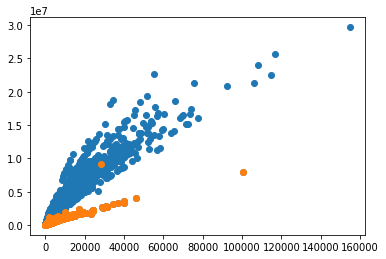

In [190]:
dd.values()
xs = [x[0] for x in dd.values()]
ys = [x[1] for x in dd.values()]
plt.scatter(xs, ys)
xs = [x[0] for x in dd_w.values()]
ys = [x[1] for x in dd_w.values()]
plt.scatter(xs, ys)

In [3]:
site_kw_occ_dict = site_kw_occ_dict_48
site_cost_dict = site_cost_dict_48

In [4]:
import importlib
importlib.reload(data_cleaning_cmm)
# Base model
import deployment_models_cmm

importlib.reload(deployment_models_cmm)
importlib.reload(solve_models_functions_cmm)


<module 'solve_models_functions_cmm' from '/Users/clairemorton/Documents/__PSE/sgc-deployment-scenarios/solve_models_functions_cmm.py'>

In [5]:
importlib.reload(locate_site_bgs_cmm)
from locate_site_bgs_cmm import (sites_bgs_dict)

In [6]:
# Load sites data
ca_albers_nad83 = 'NAD_1983_California_Teale_Albers_FtUS'
nad83 = 'EPSG:4269'
wgs84 = 'EPSG:4326'

# Building candidate sites GeoDataFrame
sites_path = os.path.join(os.getcwd(), 'data', 'candidate_site_campuses_2021-11-17', 'candidate_sites_campuses.csv')
sites_df_raw = pd.read_csv(sites_path)
sites_df_raw = sites_df_raw.loc[sites_df_raw['cat_site'] != 'X', ['id_site', 'type_site', 'cat_site', 'SQFT_ROOF', 'LON', 'LAT']]
sites_geom = gpd.points_from_xy(sites_df_raw.LON, sites_df_raw.LAT, crs = nad83)
sites_gdf = gpd.GeoDataFrame(sites_df_raw, geometry = sites_geom, crs = nad83)

In [72]:
sites_gdf_noschools = sites_gdf.loc[sites_gdf['cat_site'].isin(['W', 'CC'])]

In [94]:
sites = list(sites_gdf_noschools['id_site'])
dist_to_site_contra_costa_df_noschools = dist_to_site_contra_costa_df[np.intersect1d(dist_to_site_contra_costa_df.columns, sites)]
dist_to_site_contra_costa_walk_cf_transit_df_noschools = dist_to_site_contra_costa_walk_cf_transit_df[np.intersect1d(dist_to_site_contra_costa_walk_cf_transit_df.columns, sites)]

In [7]:
# match sites to the walkability fo the block groups they're in
for site, bg in sites_bgs_dict.items():
    sites_bgs_dict[site] = blockgroup_walkability_dict.get(bg)

In [204]:
# Run models

max_cost = 2000000 # $ that we can spend on hubs
max_distance_walk = 1
max_distance_drive = 1000
conversion_walk_transit = 1290 # seconds/mile to convert distance matrix to miles (miles used in survey)

#dist_to_site_contra_costa_df
statewide_cc = model_pop_served_max(dist_to_site_contra_costa_df, max_cost, site_cost_dict, site_kw_occ_dict, max_distance_drive)
local_cc = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_contra_costa_walk_cf_transit_df.copy()/conversion_walk_transit), 
                                                           max_cost, site_cost_dict, site_kw_occ_dict, max_distance_walk, CES = False, walk_pop = True)

In [203]:
# Run no schools models

max_cost = 2000000 # $ that we can spend on hubs
max_distance_walk = 1
max_distance_drive = 1000
conversion_walk_transit = 1290 # seconds/mile to convert distance matrix to miles (miles used in survey)

#dist_to_site_contra_costa_df
statewide_cc_noschools = model_pop_served_max(dist_to_site_contra_costa_df_noschools, max_cost, site_cost_dict, site_kw_occ_dict, max_distance_drive)
local_cc_noschools = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_contra_costa_walk_cf_transit_df_noschools.copy()/conversion_walk_transit), 
                                                           max_cost, site_cost_dict, site_kw_occ_dict, max_distance_walk, CES = False, walk_pop = True)

/Users/clairemorton/Documents/__PSE/sgc-deployment-scenarios/solve_models_functions_cmm.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/clairemorton/Documents/__PSE/sgc-deployment-scenarios/solve_models_functions_cmm.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



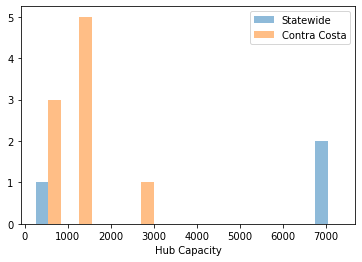

In [208]:
plot_capacity([statewide_cc, 
              local_cc],
              ["Statewide", 
                "Contra Costa"],
             "")

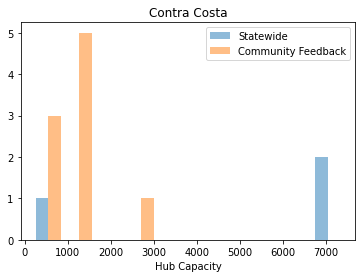

In [101]:
plot_capacity([statewide_cc_noschools, 
              local_cc_noschools],
              ["Statewide", 
                "Community Feedback"],
             "Contra Costa")

In [219]:
def map_hubs(hubs_yn, sites_gdf):
    sites = pd.DataFrame(columns = ['LAT', 'LON'])
    hubs = hubs_yn.loc[hubs_yn['BUILT'] == 1].index
    for site in hubs:
        site_pt = locate(sites_gdf, site, 'id_site')
        sites.loc[len(sites.index)] = site_pt
    fig = px.scatter_mapbox(lat=sites['LAT'], lon=sites['LON'], 
                           #mapbox_style="carto-positron", 
                            mapbox_style = "open-street-map",
                            zoom=8.75, color_discrete_sequence = ["black"],
                           center=dict(lat=37.94096449850928, 
                                     lon = -122.05482400530848),
                           title = "Recommended Sites")
    fig.show()

In [220]:
map_hubs(statewide_cc, sites_gdf)

In [221]:
map_hubs(local_cc, sites_gdf)

In [64]:
map_hubs(local_cc_notrans, sites_gdf)

In [13]:
map_hubs(var_hub_yn_contra_costa_walkability, sites_gdf)

In [14]:
map_hubs(var_hub_yn_contra_costa_walkability_ces, sites_gdf)

In [15]:
map_hubs(var_hub_yn_contra_costa_walk_pop, sites_gdf)

In [14]:
map_hubs(var_hub_yn_contra_costa_walk_cf,sites_gdf)

In [16]:
map_hubs(var_hub_yn_contra_costa_walkability_walk_pop, sites_gdf)

In [15]:
map_hubs(var_hub_yn_contra_costa_walkability_walk_pop_cf, sites_gdf)

These maps show that, even without a distance between built hubs constraint, the models that incorporate the amount of the population that we estimate is walking do the best job of spreading out hubs.

In [123]:
type_dist([statewide_cc, local_cc],
              ["State",
               "Local"],
          sites_gdf)


 State
W    1.0
Name: cat_site, dtype: float64

 Local
W      0.812500
CC     0.109375
Sec    0.046875
Pri    0.031250
Name: cat_site, dtype: float64
